In [5]:
import numpy as np
import pandas as pd
import kagglehub

In [20]:
df = pd.read_csv(r'C:\Users\subho\Downloads\archive (1)\WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer



In [21]:
df.drop(columns=["customerID"], inplace=True)


df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


y = df["Churn"]  
X = df.drop(columns=["Churn"])  


num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


X_post = preprocessor.fit_transform(X)

print("Shape before preprocessing:", X.shape)
print("Shape after preprocessing:", X_post.shape)


Shape before preprocessing: (7043, 19)
Shape after preprocessing: (7043, 45)


C:\Users\subho\AppData\Local\Temp\ipykernel_21964\1719886299.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [17]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Explained variance ratio per component: [0.2722 0.181 ]
Total variance explained by 2 PCs: 0.4532


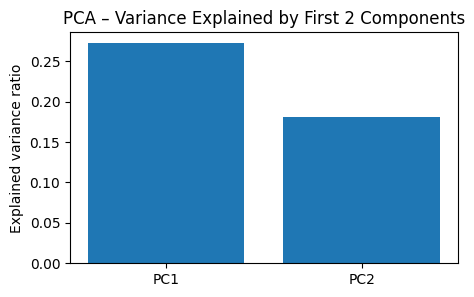

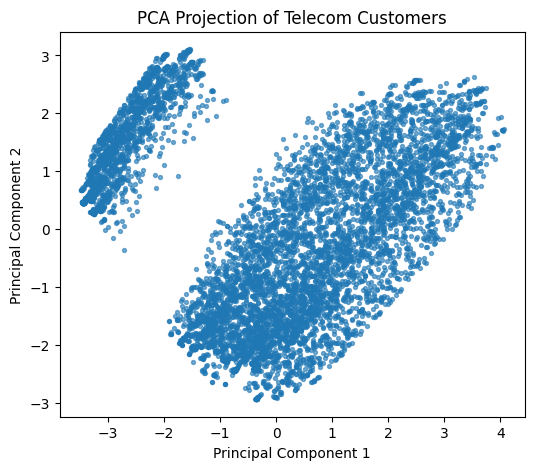

In [22]:


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_post.toarray() if hasattr(X_post, "toarray") else X_post)


explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

print("Explained variance ratio per component:", explained.round(4))
print(f"Total variance explained by 2 PCs: {cum_explained[-1]:.4f}")

# 3. Plot variance (scree plot)
plt.figure(figsize=(5,3))
plt.bar(["PC1", "PC2"], explained)
plt.ylabel("Explained variance ratio")
plt.title("PCA – Variance Explained by First 2 Components")
plt.show()

# 4. 2D scatter of PCA projection (unlabeled)
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=8, alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Telecom Customers")
plt.show()


In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

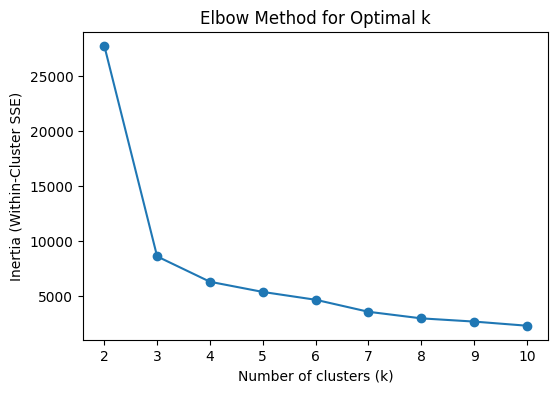

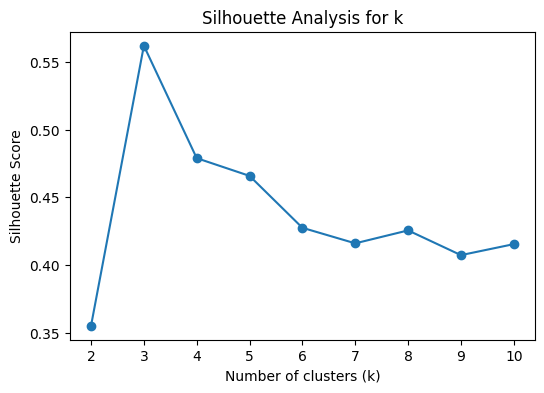

Best k based on silhouette: 3 (Score = 0.562)


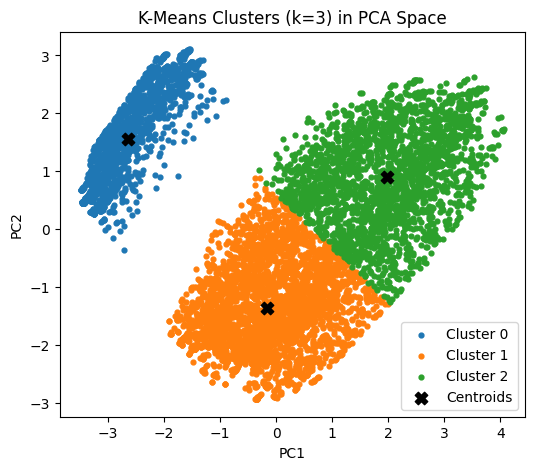

In [24]:


# Assume X_pca exists from Part B

inertias = []
sil_scores = []
K_range = range(2, 11)  # test k=2..10

# 1. Compute inertia and silhouette for each K
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_pca)
    
    inertias.append(km.inertia_)
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)

# 2. Plot Elbow curve
plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

# 3. Plot Silhouette scores
plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for k")
plt.show()

# 4. Select best k (highest silhouette score)
best_k = K_range[np.argmax(sil_scores)]
print(f"Best k based on silhouette: {best_k} (Score = {max(sil_scores):.3f})")

# 5. Final K-Means fit with chosen k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_pca)

# 6. Plot clusters in PCA space
plt.figure(figsize=(6,5))
for c in range(best_k):
    mask = (cluster_labels == c)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=12, label=f"Cluster {c}")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='black', marker='X', s=80, label='Centroids')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means Clusters (k={best_k}) in PCA Space")
plt.legend()
plt.show()


In [25]:
# ========= Part D: Cluster Analysis =========

# We’ll assume you still have these variables from earlier parts:
# df  -> original dataframe (with 'Churn')
# X   -> features (without 'Churn')
# y   -> churn label
# cluster_labels -> from final KMeans in Part C
# best_k -> chosen K value

# 1. Reattach cluster labels
analysis_df = X.copy()
analysis_df["cluster"] = cluster_labels
analysis_df["Churn"] = y

# 2. Numeric summaries
num_summary = analysis_df.groupby("cluster")[["tenure", "MonthlyCharges", "TotalCharges"]].mean()
print("=== Average numeric values by cluster ===")
print(num_summary.round(2))

# 3. Churn rate per cluster
churn_rate = analysis_df.groupby("cluster")["Churn"].apply(lambda s: (s == "Yes").mean())
print("\n=== Churn Rate by Cluster ===")
print((churn_rate * 100).round(1).astype(str) + "%")

# 4. Selected categorical distributions (optional but insightful)
cat_features = ["Contract", "InternetService", "PaymentMethod", "PaperlessBilling"]
for col in cat_features:
    if col in analysis_df.columns:
        summary = (
            analysis_df.groupby("cluster")[col]
            .value_counts(normalize=True)
            .rename("proportion")
            .reset_index()
            .pivot(index="cluster", columns=col, values="proportion")
            .fillna(0)
        )
        print(f"\n=== {col} distribution by cluster ===")
        print((summary * 100).round(1).astype(str) + "%")

# 5. Optional: simple heuristic labels for segments
segment_labels = {}
for c in range(best_k):
    avg_tenure = num_summary.loc[c, "tenure"]
    avg_charge = num_summary.loc[c, "MonthlyCharges"]
    churn = churn_rate.loc[c]
    
    if avg_tenure < 12 and churn > 0.3:
        label = "New/At-Risk Customers"
    elif avg_tenure >= 24 and churn < 0.15:
        label = "Loyal Long-Term Customers"
    elif avg_charge > 80 and churn > 0.25:
        label = "High-Spend At-Risk"
    else:
        label = "Moderate Mixed Group"
    
    segment_labels[c] = label

print("\n=== Segment interpretation ===")
for c, name in segment_labels.items():
    print(f"Cluster {c}: {name}")

# 6. Attach readable segment names and save
analysis_df["Segment"] = analysis_df["cluster"].map(segment_labels)
analysis_df.to_csv("TelcoClusterAnalysis.csv", index=False)
print("\nSaved detailed cluster assignments to TelcoClusterAnalysis.csv")


=== Average numeric values by cluster ===
         tenure  MonthlyCharges  TotalCharges
cluster                                      
0         30.55           21.08        668.10
1         15.44           68.26       1042.97
2         57.32           88.88       5090.85

=== Churn Rate by Cluster ===
cluster
0     7.4%
1    44.1%
2    14.6%
Name: Churn, dtype: object

=== Contract distribution by cluster ===
Contract Month-to-month One year Two year
cluster                                  
0                 34.3%    23.9%    41.8%
1                 87.2%    10.5%     2.3%
2                 23.6%    33.6%    42.8%

=== InternetService distribution by cluster ===
InternetService    DSL Fiber optic      No
cluster                                   
0                 0.0%        0.0%  100.0%
1                47.0%       53.0%    0.0%
2                39.5%       60.5%    0.0%

=== PaymentMethod distribution by cluster ===
PaymentMethod Bank transfer (automatic) Credit card (automatic)  \